## 3.a Enrol Random Students to Courses

**GitHub Link:** [3.a Enrol Random Students to Courses](https://github.com/khhaledahmaad/attendance_monitoring_via_sms/blob/main/nbs/03a_enrol_random_students_to_courses.ipynb)

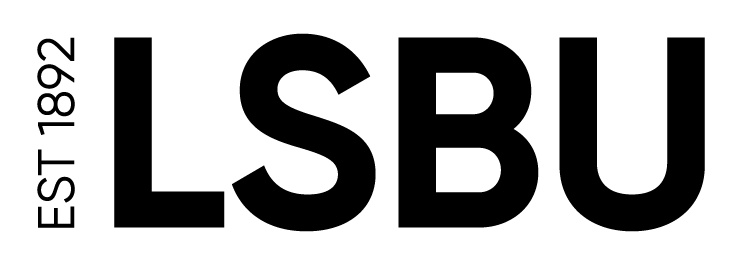

**Student Name:** Khaled Ahmed

**Student ID:** 3821656

**Project Title:** Attendance Monitoring via SMS   

**Course:** BEng Hons Computer Engineering

**Project Supervisor:** Dr Oswaldo Cadenas

## Introduction
This notebook shows how to retrieve text messages sent by students to a Twilio number for a specific time duration to create an attendance based on the course date time data available on course datasets stored in .csv files.

## Objectives
-  Enroll random students to different courses
-  Export the courses with randomly assigned studends

In [1]:
# Import libraries
import os
import pathlib
import secrets
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime
from twilio.rest import Client
from flask import Flask
from flask_mail import Mail, Message

In [2]:
# Set paths
base_dir = pathlib.Path().absolute().parent

# Path to all data directories
data = base_dir/'datasets'

# Path to credentials data
credentials = data/'credentials'

# Path to state data
state = data/'state'

# Path to raw data
raw = data/'raw'

# Path to processed data
processed = data/'processed'

# Path to environment variables
env_vars = pathlib.Path(base_dir/'env_vars')

In [3]:
# Load student table
df_students = pd.read_csv(credentials/'students.csv')
# Preview
print(df_students.shape)
df_students.head()

(20, 5)


,id,first_name,last_name,student_id,email
0,1,Khaled,Ahmed,3821656,ahmedk56@lsbu.ac.uk
1,2,Bobby,Hurley,3821657,hurleyb57@lsbu.ac.uk
2,3,Porter,Mckinney,3821658,mckinneyp58@lsbu.ac.uk
3,4,Laura,Meyers,3821659,meyersl59@lsbu.ac.uk
4,5,Natalya,Skinner,3821660,skinnern60@lsbu.ac.uk


In [4]:
# Load course table
df_courses = pd.read_csv(credentials/'courses.csv')
# Preview
print(df_courses.shape)
df_courses.head()

(10, 8)


,id,course_name,course_code,tutor,email,teaching_day,start_time,end_time
0,1,Engineering Mathematics and Modelling,101,Jon Selig,seligjm@lsbu.ac.uk,Monday,09:00,11:00
1,2,Digital Logic Design,102,Oswaldo Cadenas,cadenaso@lsbu.ac.uk,Tuesday,10:00,12:00
2,3,Cybersecurity and Cryptography,103,Stavros Dimitriou,dimitrsa@lsbu.ac.uk,Wednesday,12:00,14:00
3,4,Final Year Project,104,Fang Duan,duanf@lsbu.ac.uk,Thursday,12:00,14:00
4,5,Computer Systems and Software Engineering,105,Ya Bao,baoyb@lsbu.ac.uk,Friday,13:00,15:00


In [5]:
# All Students
students = df_students.student_id.dropna().unique()
students

array([3821656, 3821657, 3821658, 3821659, 3821660, 3821661, 3821662,
       3821663, 3821664, 3821665, 3821666, 3821667, 3821668, 3821669,
       3821670, 3821671, 3821672, 3821673, 3821674, 3821675], dtype=int64)

In [6]:
# All courses
courses = df_courses.course_name.dropna().unique()
courses

array(['Engineering Mathematics and Modelling', 'Digital Logic Design',
       'Cybersecurity and Cryptography', 'Final Year Project',
       'Computer Systems and Software Engineering',
       'Desging and Practice', 'Engineering Computing',
       'Engineering Principles', 'Innovation and Enterprise',
       'Computer Networks'], dtype=object)

In [7]:
# Select random 5 students
df_5 = df_students.iloc[:,1:].sample(5).sort_values(['first_name', 'last_name']).reset_index(drop=True)
# Preview
df_5

,first_name,last_name,student_id,email
0,Cade,Higgins,3821665,higginsc65@lsbu.ac.uk
1,Khaled,Ahmed,3821656,ahmedk56@lsbu.ac.uk
2,Matilda,Fritz,3821674,fritzm74@lsbu.ac.uk
3,Melina,Haney,3821661,haneym61@lsbu.ac.uk
4,Sofia,Lee,3821662,lees62@lsbu.ac.uk


In [8]:
# Assign the random 5 students to a random course
df_5[['course_name', 'course_code']] = df_courses.course_name[0], df_courses.course_code[0]
# Preview
df_5

,first_name,last_name,student_id,email,course_name,course_code
0,Cade,Higgins,3821665,higginsc65@lsbu.ac.uk,Engineering Mathematics and Modelling,101
1,Khaled,Ahmed,3821656,ahmedk56@lsbu.ac.uk,Engineering Mathematics and Modelling,101
2,Matilda,Fritz,3821674,fritzm74@lsbu.ac.uk,Engineering Mathematics and Modelling,101
3,Melina,Haney,3821661,haneym61@lsbu.ac.uk,Engineering Mathematics and Modelling,101
4,Sofia,Lee,3821662,lees62@lsbu.ac.uk,Engineering Mathematics and Modelling,101


In [9]:
# Re-arrange
df_5 = df_5[['course_name', 'course_code', 'first_name', 'last_name', 'student_id', 'email']]
df_5.head()

,course_name,course_code,first_name,last_name,student_id,email
0,Engineering Mathematics and Modelling,101,Cade,Higgins,3821665,higginsc65@lsbu.ac.uk
1,Engineering Mathematics and Modelling,101,Khaled,Ahmed,3821656,ahmedk56@lsbu.ac.uk
2,Engineering Mathematics and Modelling,101,Matilda,Fritz,3821674,fritzm74@lsbu.ac.uk
3,Engineering Mathematics and Modelling,101,Melina,Haney,3821661,haneym61@lsbu.ac.uk
4,Engineering Mathematics and Modelling,101,Sofia,Lee,3821662,lees62@lsbu.ac.uk


In [10]:
# Create a loop to enrol random student to each course
for i in range(len(df_courses)):
    # Select random 5 students
    df_5 = df_students.iloc[:,1:].sample(5).sort_values(['first_name', 'last_name']).reset_index(drop=True)
    # Assign the random 5 students to a random course
    df_5[['course_name', 'course_code']] = df_courses.course_name[i], df_courses.course_code[i]
    # Re-arrange
    df_5 = df_5[['course_name', 'course_code', 'first_name', 'last_name', 'student_id', 'email']]
    df_5.to_csv(credentials/'enrolled'/f'{df_courses.course_code[i]}_enrolled_students.csv', index=False)
    print(f'{len(df_5)} students assigned to {df_courses.course_name[i]}!')

5 students assigned to Engineering Mathematics and Modelling!
5 students assigned to Digital Logic Design!
5 students assigned to Cybersecurity and Cryptography!
5 students assigned to Final Year Project!
5 students assigned to Computer Systems and Software Engineering!
5 students assigned to Desging and Practice!
5 students assigned to Engineering Computing!
5 students assigned to Engineering Principles!
5 students assigned to Innovation and Enterprise!
5 students assigned to Computer Networks!


### Summary
In this notebook it was demonstrated how to:
-  Enroll random students to different courses
-  Export the courses with randomly assigned studends

<center><b>Author</b></center>

| Name | Date Created | Last Modified |
|------|--------------|---------------|
|Khaled Ahmed | 25/01/2023 | 25/01/2023|